# Amortized Inference for a NLME Model

## Training Phase

In [1]:
gpu_id = 0

model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde',
              'pharmacokinetic_model', 'clairon_small_model'][-2]
if model_name == 'fröhlich-detailed' or model_name == 'pharmacokinetic_model' or 'clairon' in model_name:
    from juliacall import Main as jl  # needed for cluster to load julia

# specify which model to use
network_idx = 0
load_best_network = False

# load necessary packages
import numpy as np
import pandas as pd

# for plots
import matplotlib.pyplot as plt
from tqdm import tqdm

# minor stuff
from datetime import datetime
from time import perf_counter

load BayesFlow package (https://bayesflow.readthedocs.io/)

In [2]:
from bayesflow.simulation import GenerativeModel
from bayesflow import diagnostics

/Users/jonas.arruda/miniconda/envs/amortizedNLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# example training
max_epochs = 10
iterations_per_epoch = 100
# show or save plots
show_plots = True
    
# training params
early_stopping = False
presimulate = False
train_network = False
batch_size = 128
max_to_keep = 3  # standard 3, if all should be saved: set to max_epochs

## Load model


In [4]:
presimulation_path = 'data/'

if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple
    model = FroehlichModelSimple(network_idx=network_idx, load_best=load_best_network)
    
    use_presimulation = False
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed
    model = FroehlichModelDetailed(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_froehlich_large'

elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    model = FroehlichModelSDE(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_froehlich_sde'
    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    model = PharmacokineticModel(network_idx=network_idx, load_best=load_best_network)
    
    use_presimulation = True
    presimulation_path += 'presimulations_pharma'
    
elif model_name == 'clairon_small_model':
    from models.clairon_small_model import ClaironSmallModel
    model = ClaironSmallModel(network_idx=network_idx, load_best=load_best_network)

    use_presimulation = True
    presimulation_path += 'presimulations_small_clairon'
else:
    raise NotImplementedError('model not implemented')

  Activating project at `~/PyCharm Projects/Amortized-NLME/models/SimulatorPharma`


using 2 layers of MultiConv1D, a bidirectional LSTM with 256 units and a dense layer with output dimension 10 as summary network
using a 7-layer cINN as inference network
prior mean: [-5.   6.5  2.5  2.5  6.5  0.   6.5 -3.  -3.  -3.   0. ]
prior covariance diagonal: [4.5 1.  1.  1.  1.  1.  1.  4.5 4.5 4.5 1. ]
Using the PharmacokineticModel


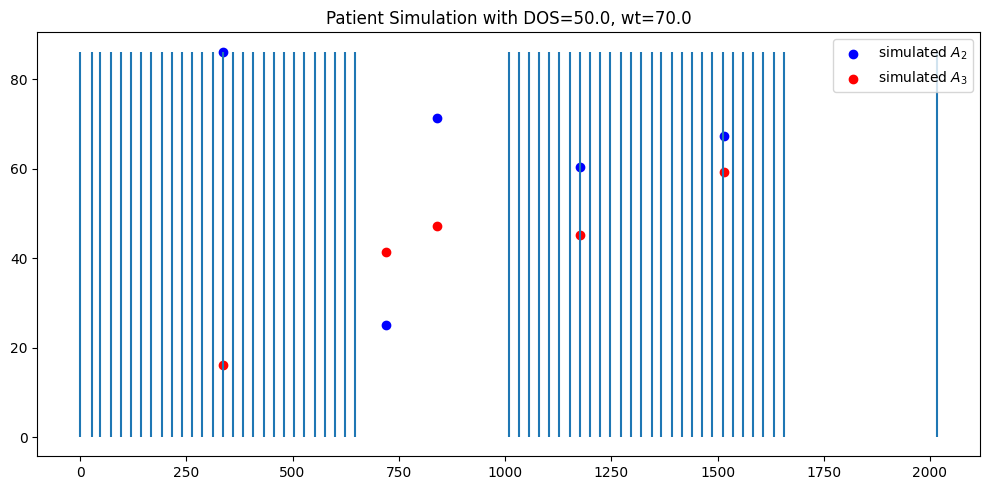

In [5]:
if show_plots:
    model.print_and_plot_example()

In [6]:
from juliacall import Pkg as jlPkg

In [ ]:
jlPkg.update()

In [ ]:
network_name = model.network_name
if network_name is None:
    network_name = 'amortizer-' + str(datetime.now())
print(network_name)

path_store_network = 'networks/' + network_name

In [ ]:
if presimulate:
    # sleep(int(job_array_id) % 200)  # so batch file does not get overwritten

    generative_model = GenerativeModel(model.prior, model.build_simulator(),
                                       simulator_is_batched=True,
                                       prior_is_batched=True)
    start_time = perf_counter()
    np.random.seed(42)
    generative_model.presimulate_and_save(batch_size, folder_path=presimulation_path,
                                          iterations_per_epoch=iterations_per_epoch,
                                          epochs=max_epochs,
                                          disable_user_input=True)
                                          # extend_from=int(job_array_id)*max_epochs)
    end_time = perf_counter()
    print(f'simulation time: {(end_time-start_time)/60} minutes')

In [ ]:
generative_model = GenerativeModel(model.prior, model.build_simulator(),
                                       simulator_is_batched=True,
                                       prior_is_batched=True)

## Training

In [ ]:
trainer = model.build_trainer(path_store_network)

each epoch a number of iterations each with batch_size many simulations is performed

In [ ]:
history = {}
if True: #train_network and not use_presimulation:
    # simulation is done whenever needed
    start_time = perf_counter()
    history = trainer.train_online(epochs=max_epochs,
                                  iterations_per_epoch=iterations_per_epoch,
                                  batch_size=batch_size,
                                  early_stopping=early_stopping,
                                  validation_sims=iterations_per_epoch)
    end_time = perf_counter()
    print(f'training time: {(end_time-start_time)/60} minutes')

In [ ]:
if train_network and use_presimulation:
    trainer._setup_optimizer(optimizer=None,
                             epochs=max_epochs,
                             iterations_per_epoch=iterations_per_epoch)

In [ ]:
if train_network and use_presimulation:
    # simulation done before
    start_time = perf_counter()
    history = trainer.train_from_presimulation(presimulation_path=presimulation_path,
                                                  optimizer=trainer.optimizer,
                                                  max_epochs=max_epochs,
                                                  early_stopping=early_stopping,
                                                  validation_sims=iterations_per_epoch)

    end_time = perf_counter()
    print(f'training time: {(end_time-start_time)/60} minutes')

In [ ]:
# load or save losses
if train_network:
    history['train_losses'].to_csv(f"output/losses/{network_name}_train_losses.csv")
    history['val_losses'].to_csv(f"output/losses/{network_name}_val_losses.csv")
else:
    train_losses = pd.read_csv(f"output/losses/{network_name}_train_losses.csv", index_col=0)
    val_losses = pd.read_csv(f"output/losses/{network_name}_val_losses.csv", index_col=0)
    history = {'train_losses': train_losses,
              'val_losses': val_losses}

In [ ]:
fig_losses = diagnostics.plot_losses(history['train_losses'], history['val_losses'])
#fig_losses.savefig(f'plots/calibration/{network_name}_fig_losses.png')

In [ ]:
if model_name == 'clairon_small_model':
    from models.clairon_small_model import convert_to_observables, batch_simulator
    test_patients = model.load_data(25)
    patients_posterior_draws = model.draw_posterior_samples(data=test_patients, n_samples=100)
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import convert_output_to_simulation, batch_simulator
    test_patients = model.load_data(n_data=25)
    patients_posterior_draws = model.draw_posterior_samples(data=test_patients, n_samples=100)

In [ ]:
if 'pharmacokinetic_model' == model_name:
    rows = 5
    fig, ax = plt.subplots(rows, int(np.ceil(len(test_patients) / rows)),# sharey='all',
                           tight_layout=True, figsize=(10, rows*3))
    axis = ax.flatten()
    
    
    for p_id in tqdm(range(len(test_patients))):
        y, doses_time_points, DOS, wt = convert_output_to_simulation(test_patients[p_id])
        t_measurements = np.linspace(0, y[-1, -1]+100, 100)
        sim_data = batch_simulator(patients_posterior_draws[p_id],
                             wt=wt,
                             DOS=DOS,
                             t_measurement=t_measurements,
                             t_doses=doses_time_points,
                             with_noise=False)
        
        y1_full = []
        y2_full = []
        for s in sim_data:
            y, _, _, _ = convert_output_to_simulation(s)
            y1_full.append(y[:, 0])
            y2_full.append(y[:, 1])

        axis[p_id].fill_between(t_measurements, np.percentile(y1_full, 2.5, axis=0), 
                                np.percentile(y1_full, 97.5, axis=0), 
                                alpha=0.2, color='orange')
        axis[p_id].plot(t_measurements, np.median(y1_full, axis=0), 'orange')
        y, _, _, _ = convert_output_to_simulation(test_patients[p_id])
        axis[p_id].scatter(y[:, -1], y[:, 0], color='orange')
        
        axis[p_id].fill_between(t_measurements, np.percentile(y2_full, 2.5, axis=0), 
                                np.percentile(y2_full, 97.5, axis=0), 
                                alpha=0.2, color='red')
        axis[p_id].plot(t_measurements, np.median(y2_full, axis=0), 'red')
        y, _, _, _ = convert_output_to_simulation(test_patients[p_id])
        axis[p_id].scatter(y[:, -1], y[:, 1], color='red')
        
        axis[p_id].vlines(doses_time_points, axis[p_id].get_ylim()[0], axis[p_id].get_ylim()[1],
                          color='grey', alpha=0.1)
    plt.show()

In [ ]:
if 'clairon' in model_name:
    rows = 5
    fig, ax = plt.subplots(rows, int(np.ceil(len(test_patients) / rows)), sharex='all', sharey='all',
                           tight_layout=True, figsize=(10, rows*3))
    axis = ax.flatten()
    t_measurements = np.linspace(0, 700, 100)
    
    for p_id in tqdm(range(len(test_patients))):
        _, _, dose_amount, doses_time_points = convert_to_observables(test_patients[p_id])
        sim_data = batch_simulator(patients_posterior_draws[p_id],
                            t_measurements=t_measurements,
                            t_doses=doses_time_points,
                            dose_amount=dose_amount,
                            with_noise=False,
                            convert_to_bf_batch=False)
        axis[p_id].fill_between(t_measurements, np.percentile(sim_data, 2.5, axis=0), 
                                np.percentile(sim_data, 97.5, axis=0), 
                                alpha=0.2)
        axis[p_id].vlines(doses_time_points, 0, 2500, color='grey', linestyles='--', alpha=0.5)
        axis[p_id].plot(t_measurements, np.median(sim_data, axis=0), 'r')
    
        y, t_measurements_obs, _, _ = convert_to_observables(test_patients[p_id])
        axis[p_id].scatter(t_measurements_obs, y, color='g')
        #axis[p_id].set_yscale('log')
    plt.show()

## Get Posterior Parameter Samples and Plot Them Against True Values

If the training is very short, one should see only uniformly distributed estimates.

**quick and dirty validation:**


If the model can generate data that is quite uninformative, the true posterior means may differ significantly from the ground truth parameter

In [ ]:
save_plots = False

In [ ]:
new_sims = model.generate_simulations_from_prior(trainer=trainer,
                                                 simulator=model.build_simulator(),
                                                 n_samples=2500)

In [ ]:
posterior_draws = model.draw_posterior_samples(data=new_sims['summary_conditions'], n_samples=100)

In [ ]:
#fig_recovery = diagnostics.plot_recovery(post_samples=posterior_draws,
#                                         prior_samples=new_sims['parameters'],
#                                         param_names=model.log_param_names,
#                                         n_row=2)
#
#if save_plots:
#    fig_recovery.savefig(f'plots/calibration/{network_name}_fig_recovery.png')

In [ ]:
fig_sbc = diagnostics.plot_sbc_histograms(post_samples=posterior_draws,
                                          prior_samples=new_sims['parameters'],
                                          param_names=model.log_param_names)

#fig_sbc.axes[-1].set_visible(False)
if save_plots:
    fig_sbc.savefig(f'plots/calibration/{network_name}_fig_sbc2.png')

In [ ]:
fig_ecdf_diff = diagnostics.plot_sbc_ecdf(post_samples=posterior_draws,
                                          prior_samples=new_sims['parameters'],
                                          difference=True,
                                          stacked=False,
                                          param_names=model.log_param_names)

if save_plots:
    fig_ecdf_diff.savefig(f'plots/calibration/{network_name}_fig_ecdf_diff.png')

In [ ]:
fig_posterior = diagnostics.plot_posterior_2d(posterior_draws=posterior_draws[0],
                                              prior=model.prior,
                                              param_names=model.log_param_names)

if save_plots:
    fig_posterior.savefig(f'plots/calibration/{network_name}_fig_posterior.png')

## Get SBC Plots for Different Epochs

In [ ]:
ckpt_list = []# [1, 10, 100, 200, 300, 400, 500]

In [ ]:
#new_sims = model.generate_from_prior(trainer=trainer,
#                                     simulator=model.build_simulator(),
#                                     n_smaples=10000)

In [ ]:
for ckpt in ckpt_list:
    print('Load checkpoint', ckpt)
    # restore checkpoint
    trainer.checkpoint.restore(path_store_network + f'/ckpt-{ckpt}')
    # sample posterior
    posterior_draws = model.draw_posterior_samples(data=new_sims['summary_conditions'], n_samples=250)

    # make sbc plots
    fig_ecdf_diff = diagnostics.plot_sbc_ecdf(post_samples=posterior_draws,
                                              prior_samples=new_sims['parameters'],
                                              difference=True,
                                              stacked=False,
                                              param_names=model.log_param_names)
    if save_plots:
        fig_ecdf_diff.savefig(f'plots/calibration/epochs_compare/{network_name}_fig_ecdf_diff_{ckpt}_.png')
    plt.show()